<a href="https://colab.research.google.com/github/Giffy/fast.ai/blob/master/Machine%20Learning/lesson8_mnist_sgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1 Using SGD on MNIST

##2 ... about machine learning (a reminder from lesson 1)

The good news is that modern machine learning can be distilled down to a couple of key techniques that are of very wide applicability. Recent studies have shown that the vast majority of datasets can be best modeled with just two methods:

1. Ensembles of decision trees (i.e. Random Forests and Gradient Boosting Machines), mainly for structured data (such as you might find in a database table at most companies).  We looked at random forests in depth as we analyzed the Blue Book for Bulldozers dataset.

2. Multi-layered neural networks learnt with SGD (i.e. shallow and/or deep learning), mainly for unstructured data (such as audio, vision, and natural language)

In this lesson, we will start on the 2nd approach (a neural network with SGD) by analyzing the MNIST dataset.  You may be surprised to learn that **logistic regression is actually an example of a simple neural net**!

##3 About The Data

In this lesson, we will be working with MNIST, a classic data set of hand-written digits.  Solutions to this problem are used by banks to automatically recognize the amounts on checks, and by the postal service to automatically recognize zip codes on mail.

<img src="https://raw.githubusercontent.com/Giffy/fast.ai/master/Machine%20Learning/imgs/mnist.png" alt="" style="width: 60%"/>

A matrix can represent an image, by creating a grid where each entry corresponds to a different pixel.

<img src="https://raw.githubusercontent.com/Giffy/fast.ai/master/Machine%20Learning/imgs/digit.gif" alt="digit" style="width: 55%"/>

  (Source: [Adam Geitgey
](https://medium.com/@ageitgey/machine-learning-is-fun-part-3-deep-learning-and-convolutional-neural-networks-f40359318721))


###3.0 Google Colab setup
Installs fast.ai 0.7.0 and the required libraries to run the notebook.

Also downloads the required datasets.

In [1]:
print (" Installing FastAI libraries... (takes 2 min) ")
!pip install fastai==0.7.0 > /dev/null
print ("\n Installing required libraries...")
!pip install torchtext==0.2.3 > /dev/null
!git clone https://github.com/fastai/fastai.git fastai_ml
!ln -s fastai_ml/courses/ml1/fastai/ fastai

 Installing FastAI libraries... (takes 2 min) 

 Installing required libraries...
fatal: destination path 'fastai_ml' already exists and is not an empty directory.


In [2]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag

platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\10/'    
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
version='1.0.0'

torch_url=f"http://download.pytorch.org/whl/{accelerator}/torch-{version}-{platform}-linux_x86_64.whl"

!pip install -U {torch_url} torchvision


     |████████████████████████████████| 753.6MB 1.1MB/s 
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.2.2.post3)
ERROR: fastai 0.7.0 has requirement torch<0.4, but you'll have torch 1.0.0 which is incompatible.
  Found existing installation: torch 0.3.1
    Uninstalling torch-0.3.1:
      Successfully uninstalled torch-0.3.1


###3.1 Imports and data

**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

We will be using the fastai library, which is still in pre-alpha.  If you are accessing this course notebook, you probably already have it downloaded, as it is in the same Github repo as the course materials.

We use [symbolic links](https://kb.iu.edu/d/abbe) (often called *symlinks*) to make it possible to import these from your current directory.  For instance, I ran:

    ln -s ../../fastai
    
in the terminal, within the directory I'm working in, `home/fastai/courses/ml1`.

In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.imports import *
from fastai.io import *
from fastai.torch_imports import *
import torch

###3.2 Download

Let's download, unzip, and format the data.

In [0]:
path = 'data/mnist/'

In [0]:
import os
os.makedirs(path, exist_ok=True)

In [0]:
URL='http://deeplearning.net/data/mnist/'
FILENAME='mnist.pkl.gz'

def load_mnist(filename):
    return pickle.load(gzip.open(filename, 'rb'), encoding='latin-1')

In [0]:
get_data(URL+FILENAME, path+FILENAME)
((x, y), (x_valid, y_valid), _) = load_mnist(path+FILENAME)

In [9]:
type(x), x.shape, type(y), y.shape

(numpy.ndarray, (50000, 784), numpy.ndarray, (50000,))

###3.3 Normalize

Many machine learning algorithms behave better when the data is *normalized*, that is when the mean is 0 and the standard deviation is 1. We will subtract off the mean and standard deviation from our training set in order to normalize the data:

In [10]:
mean = x.mean()
std = x.std()

x=(x-mean)/std
mean, std, x.mean(), x.std()

(0.13044983, 0.3072898, -3.1638146e-07, 0.99999934)

Note that for consistency (with the parameters we learn when training), we subtract the mean and standard deviation of our training set from our validation set. 

In [11]:
x_valid = (x_valid-mean)/std
x_valid.mean(), x_valid.std()

(-0.005850922, 0.99243325)

###3.4 Look at the data

In any sort of data science work, it's important to look at your data, to make sure you understand the format, how it's stored, what type of values it holds, etc. To make it easier to work with, let's reshape it into 2d images from the flattened 1d format.

####3.4.1 Helper methods

In [0]:
def show(img, title=None):
    plt.imshow(img, cmap="gray")
    if title is not None: plt.title(title)

In [0]:
def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], cmap='gray')

####3.4.2 Plots 

In [14]:
x_valid.shape

(10000, 784)

In [15]:
x_imgs = np.reshape(x_valid, (-1,28,28)); x_imgs.shape

(10000, 28, 28)

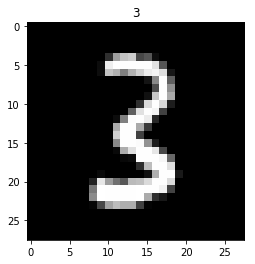

In [16]:
show(x_imgs[0], y_valid[0])

In [17]:
y_valid.shape

(10000,)

It's the digit 3!  And that's stored in the y value:

In [18]:
y_valid[0]

3

We can look at part of an image:

In [19]:
x_imgs[0,10:15,10:15]

array([[-0.42452, -0.42452, -0.42452, -0.42452,  0.17294],
       [-0.42452, -0.42452, -0.42452,  0.78312,  2.43567],
       [-0.42452, -0.27197,  1.20261,  2.77889,  2.80432],
       [-0.42452,  1.76194,  2.80432,  2.80432,  1.73651],
       [-0.42452,  2.20685,  2.80432,  2.80432,  0.40176]], dtype=float32)

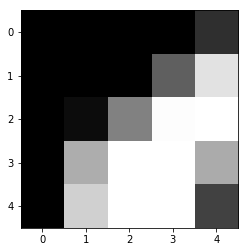

In [20]:
show(x_imgs[0,10:15,10:15])

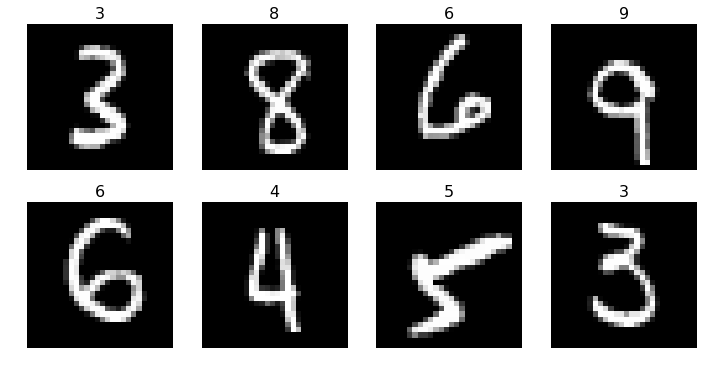

In [21]:
plots(x_imgs[:8], titles=y_valid[:8])

##4 Neural Networks

We will take a deep look *logistic regression* and how we can program it ourselves. We are going to treat it as a specific example of a shallow neural net.

**What is a neural network?**

A *neural network* is an *infinitely flexible function*, consisting of *layers*.  A *layer* is a linear function such as matrix multiplication followed by a non-linear function (the *activation*).

One of the tricky parts of neural networks is just keeping track of all the vocabulary! 

###4.1 Functions, parameters, and training

A **function** takes inputs and returns outputs. For instance, $f(x) = 3x + 5$ is an example of a function.  If we input $2$, the output is $3\times 2 + 5 = 11$, or if we input $-1$, the output is $3\times -1 + 5 = 2$

Functions have **parameters**. The above function $f$ is $ax + b$, with parameters a and b set to $a=3$ and $b=5$.

Machine learning is often about learning the best values for those parameters.  For instance, suppose we have the data points on the chart below.  What values should we choose for $a$ and $b$?

<img src="https://raw.githubusercontent.com/Giffy/fast.ai/master/Machine%20Learning/imgs/sgd2.gif" alt="" style="width: 70%"/>

In the above gif from fast.ai's deep learning course, [intro to SGD notebook](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/sgd-intro.ipynb)), an algorithm called stochastic gradient descent is being used to learn the best parameters to fit the line to the data (note: in the gif, the algorithm is stopping before the absolute best parameters are found).  This process is called **training** or **fitting**.

Most datasets will not be well-represented by a line.  We could use a more complicated function, such as $g(x) = ax^2 + bx + c + \sin d$.  Now we have 4 parameters to learn: $a$, $b$, $c$, and $d$.  This function is more flexible than $f(x) = ax + b$ and will be able to accurately model more datasets.

Neural networks take this to an extreme, and are infinitely flexible.  They often have thousands, or even hundreds of thousands of parameters.  However the core idea is the same as above.  The neural network is a function, and we will learn the best parameters for modeling our data.

##5 PyTorch

We will be using the open source [deep learning library, fastai](https://github.com/fastai/fastai), which provides high level abstractions and best practices on top of PyTorch.  This is the highest level, simplest way to get started with deep learning. Please note that fastai requires Python 3 to function. It is currently in pre-alpha, so items may move around and more documentation will be added in the future.

The fastai deep learning library uses [PyTorch](http://pytorch.org/), a Python framework for dynamic neural networks with GPU acceleration, which was released by Facebook's AI team.

PyTorch has two overlapping, yet distinct, purposes.  As described in the [PyTorch documentation](http://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html):

<img src="https://raw.githubusercontent.com/Giffy/fast.ai/master/Machine%20Learning/imgs/what_is_pytorch.png" alt="pytorch" style="width: 80%"/>

The neural network functionality of PyTorch is built on top of the Numpy-like functionality for fast matrix computations on a GPU. Although the neural network purpose receives way more attention, both are very useful.  We'll implement a neural net from scratch today using PyTorch.

**Further learning**: If you are curious to learn what *dynamic* neural networks are, you may want to watch [this talk](https://www.youtube.com/watch?v=Z15cBAuY7Sc) by Soumith Chintala, Facebook AI researcher and core PyTorch contributor.

If you want to learn more PyTorch, you can try this [introductory tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) or this [tutorial to learn by examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html).

###5.1 About GPUs

Graphical processing units (GPUs) allow for matrix computations to be done with much greater speed, as long as you have a library such as PyTorch that takes advantage of them.  Advances in GPU technology in the last 10-20 years have been a key part of why neural networks are proving so much more powerful now than they did a few decades ago. 

You may own a computer that has a GPU which can be used.  For the many people that either don't have a GPU (or have a GPU which can't be easily accessed by Python), there are a few differnt options:

- **Don't use a GPU**: For the sake of this tutorial, you don't have to use a GPU, although some computations will be slower.
- **Use crestle, through your browser**: [Crestle](https://www.crestle.com/) is a service that gives you an already set up cloud service with all the popular scientific and deep learning frameworks already pre-installed and configured to run on a GPU in the cloud. It is easily accessed through your browser. New users get 10 hours and 1 GB of storage for free. After this, GPU usage is 34 cents per hour. I recommend this option to those who are new to AWS or new to using the console.
- **Set up an AWS instance through your console**: You can create an AWS instance with a GPU by following the steps in this  [fast.ai setup lesson](http://course.fast.ai/lessons/aws.html).]  AWS charges 90 cents per hour for this.

##6 Neural Net for Logistic Regression in PyTorch

In [0]:
from fastai.metrics import *
from fastai.model import *
from fastai.dataset import *

import torch.nn as nn

We will begin with the highest level abstraction: using a neural net defined by PyTorch's Sequential class.  

In [0]:
net = nn.Sequential(
    nn.Linear(28*28, 10),
    nn.LogSoftmax()
).cuda()

Each input is a vector of size `28*28` pixels and our output is of size `10` (since there are 10 digits: 0, 1, ..., 9). 

We use the output of the final layer to generate our predictions.  Often for classification problems (like MNIST digit classification), the final layer has the same number of outputs as there are classes.  In that case, this is 10: one for each digit from 0 to 9.  These can be converted to comparative probabilities.  For instance, it may be determined that a particular hand-written image is 80% likely to be a 4, 18% likely to be a 9, and 2% likely to be a 3.

In [0]:
md = ImageClassifierData.from_arrays(path, (x,y), (x_valid, y_valid))

In [25]:
x.shape

(50000, 784)

In [0]:
loss=nn.NLLLoss()
metrics=[accuracy]
opt=optim.Adam(net.parameters())

##7 Loss functions and metrics

In machine learning the **loss** function or cost function is representing the price paid for inaccuracy of predictions.

The loss associated with one example in binary classification is given by:
`-(y * log(p) + (1-y) * log (1-p))`
where `y` is the true label of `x` and `p` is the probability predicted by our model that the label is 1.

In [0]:
def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1-y)*np.log(1-p)))

In [28]:
acts = np.array([1, 0, 0, 1])
preds = np.array([0.9, 0.1, 0.2, 0.8])
binary_loss(acts, preds)

0.164252033486018

Note that in our toy example above our accuracy is 100% and our loss is 0.16. Compare that to a loss of 0.03 that we are getting while predicting cats and dogs. Exercise: play with `preds` to get a lower loss for this example. 

**Example:** Here is an example on how to compute the loss for one example of binary classification problem. Suppose for an image x with label 1 and your model gives it a prediction of 0.9. For this case the loss should be small because our model is predicting a label $1$ with high probability.

`loss = -log(0.9) = 0.10`

Now suppose x has label 0 but our model is predicting 0.9. In this case our loss is should be much larger.

`loss = -log(1-0.9) = 2.30`

- Exercise: look at the other cases and convince yourself that this make sense.
- Exercise: how would you rewrite `binary_loss` using `if` instead of `*` and `+`?

Why not just maximize accuracy? The binary classification loss is an easier function to optimize.

For multi-class classification, we use *negative log liklihood* (also known as *categorical cross entropy*) which is exactly the same thing, but summed up over all classes.

##8 Fitting the model

*Fitting* is the process by which the neural net learns the best parameters for the dataset.

In [29]:
fit(net, md, n_epochs=1, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy   
    0      0.327226   0.283316   0.9209    



[0.28331562876701355, 0.9209]

GPUs are great at handling lots of data at once (otherwise don't get performance benefit).  We break the data up into **batches**, and that specifies how many samples from our dataset we want to send to the GPU at a time.  The fastai library defaults to a batch size of 64.  On each iteration of the training loop, the error on 1 batch of data will be calculated, and the optimizer will update the parameters based on that.

An **epoch** is completed once each data sample has been used once in the training loop.

Now that we have the parameters for our model, we can make predictions on our validation set.

In [0]:
preds = predict(net, md.val_dl)

In [31]:
preds.shape

(10000, 10)

**Question**: Why does our output have length 10 (for each image)?

In [32]:
preds.argmax(axis=1)[:5]

array([3, 8, 6, 9, 6])

In [0]:
preds = preds.argmax(1)

Let's check how accurate this approach is on our validation set. You may want to compare this against other implementations of logistic regression, such as the one in sklearn. In our testing, this simple pytorch version is faster and more accurate for this problem!

In [34]:
np.mean(preds == y_valid)

0.9209

Let's see how some of our predictions look!

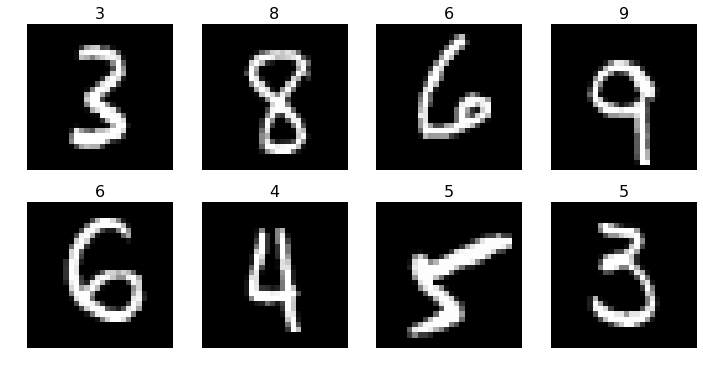

In [35]:
plots(x_imgs[:8], titles=preds[:8])

##9 Defining Logistic Regression Ourselves

Above, we used pytorch's `nn.Linear` to create a linear layer.  This is defined by a matrix multiplication and then an addition (these are also called `affine transformations`).  Let's try defining this ourselves.

Just as Numpy has `np.matmul` for matrix multiplication (in Python 3, this is equivalent to the `@` operator), PyTorch has `torch.matmul`.  

Our PyTorch class needs two things: constructor (says what the parameters are) and a forward method (how to calculate a prediction using those parameters)  The method `forward` describes how the neural net converts inputs to outputs.

In PyTorch, the optimizer knows to try to optimize any attribute of type **Parameter**.

In [0]:
def get_weights(*dims): return nn.Parameter(torch.randn(dims)/dims[0])

In [0]:
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights(28*28, 10)  # Layer 1 weights
        self.l1_b = get_weights(10)         # Layer 1 bias

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.matmul(x, self.l1_w) + self.l1_b  # Linear Layer
        x = torch.log(torch.exp(x)/(torch.exp(x).sum(dim=0)))  # Non-linear (LogSoftmax) Layer
        return x

We create our neural net and the optimizer.  (We will use the same loss and metrics from above).

In [0]:
net2 = LogReg().cuda()
opt=optim.Adam(net2.parameters())

In [39]:
fit(net2, md, n_epochs=1, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy   
    0      2.450192   2.404394   0.9068    



[2.404393862438202, 0.9068]